In [11]:
# Core libraries
import os
import numpy as np
import pandas as pd

# Audio + signal processing
import librosa

# For potential plots later (EDA, spectrogram visualisation)
import matplotlib.pyplot as plt

# For label encoding
from sklearn.preprocessing import LabelEncoder


In [12]:
AUDIO_DIR = r"C:\Users\Emna Othmani\OneDrive - ENSEA\Bureau\DEEP_LEARNING\ESC-50-master\audio"
META_PATH = r"C:\Users\Emna Othmani\OneDrive - ENSEA\Bureau\DEEP_LEARNING\ESC-50-master\meta\esc50.csv"

meta = pd.read_csv(META_PATH)
print(meta.head())
print("Number of clips:", len(meta))
print("Number of classes:", meta['category'].nunique())
print("Sample files:", os.listdir(AUDIO_DIR)[:5])


            filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A
Number of clips: 2000
Number of classes: 50
Sample files: ['1-100032-A-0.wav', '1-100038-A-14.wav', '1-100210-A-36.wav', '1-100210-B-36.wav', '1-101296-A-19.wav']


SIMPLE EDA


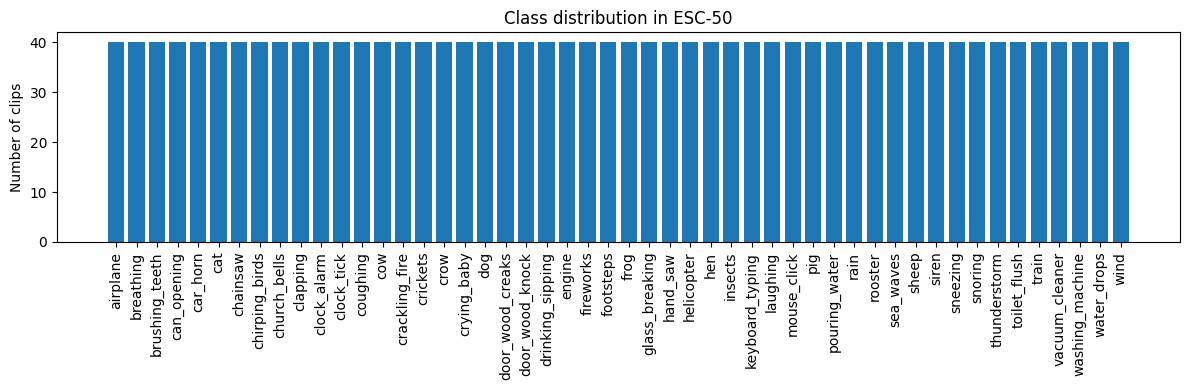

In [13]:
import matplotlib.pyplot as plt

class_counts = meta['category'].value_counts().sort_index()

plt.figure(figsize=(12, 4))
plt.bar(class_counts.index, class_counts.values)
plt.xticks(rotation=90)
plt.ylabel("Number of clips")
plt.title("Class distribution in ESC-50")
plt.tight_layout()
plt.savefig("eda_class_distribution.png", dpi=300)
plt.show()


DATA PREPARATION

In [14]:
TARGET_SR = 16000
CLIP_DURATION = 5.0  # seconds
N_SAMPLES = int(TARGET_SR * CLIP_DURATION)

def load_waveform(filename, audio_dir=AUDIO_DIR,
                  target_sr=TARGET_SR, n_samples=N_SAMPLES):
    """
    Load an ESC-50 clip, resample to target_sr, convert to mono,
    and pad/truncate to fixed length.
    """
    filepath = os.path.join(audio_dir, filename)
    y, sr = librosa.load(filepath, sr=target_sr, mono=True)

    # Pad or truncate to exactly n_samples
    if len(y) > n_samples:
        y = y[:n_samples]
    elif len(y) < n_samples:
        pad_width = n_samples - len(y)
        y = np.pad(y, (0, pad_width), mode="constant")

    # Optional: normalise amplitude
    if np.max(np.abs(y)) > 0:
        y = y / np.max(np.abs(y))

    return y


In [15]:
example_row = meta.iloc[0]
y = load_waveform(example_row['filename'])
print("Waveform shape:", y.shape)
print("Fold:", example_row['fold'], "| Class:", example_row['category'])


Waveform shape: (80000,)
Fold: 1 | Class: dog


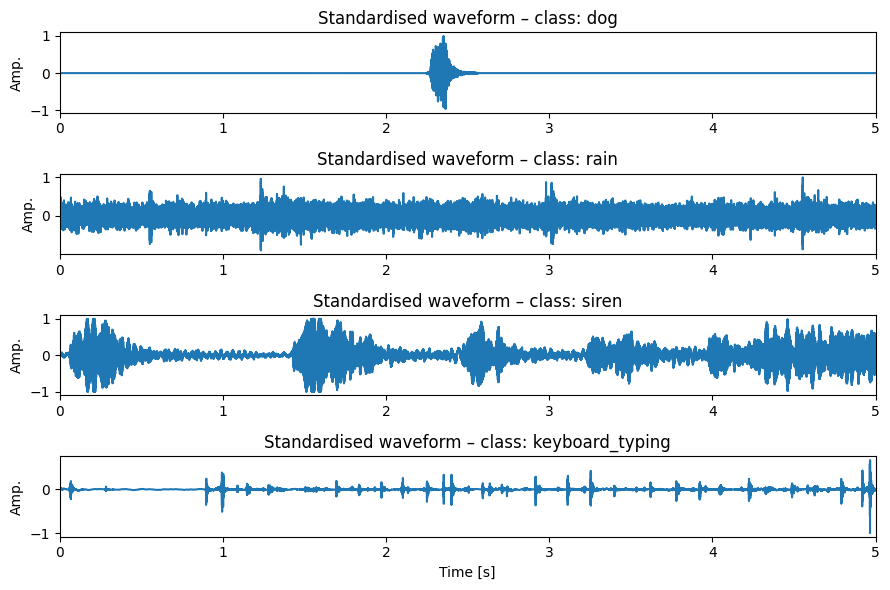

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Choose some classes to illustrate
example_classes = ["dog", "rain", "siren", "keyboard_typing"]

rows = []
for cls in example_classes:
    row_cls = meta[meta["category"] == cls].iloc[0]
    rows.append(row_cls)

duration = 5.0  # seconds
t = np.linspace(0, duration, N_SAMPLES)  # N_SAMPLES = 80000 from before

plt.figure(figsize=(9, 6))

for i, row in enumerate(rows):
    filename = row["filename"]
    label = row["category"]

    y_std = load_waveform(filename)  # mono, 16 kHz, fixed length

    plt.subplot(len(rows), 1, i + 1)
    plt.plot(t, y_std)
    plt.xlim(0, duration)
    plt.ylabel("Amp.")
    plt.title(f"Standardised waveform – class: {label}")
    if i == len(rows) - 1:
        plt.xlabel("Time [s]")

plt.tight_layout()
plt.savefig("standardised_waveforms_multi.png", dpi=300)
plt.show()


In [17]:
def extract_mfcc_sequence(y, sr=TARGET_SR, n_mfcc=40,
                          n_fft=1024, hop_length=512):
    """
    Compute an MFCC sequence (time x n_mfcc) from a waveform y.
    """
    mfcc = librosa.feature.mfcc(
        y=y,
        sr=sr,
        n_mfcc=n_mfcc,
        n_fft=n_fft,
        hop_length=hop_length
    )
    # Transpose to (time_steps, n_mfcc)
    return mfcc.T


def mfcc_mean_from_sequence(mfcc_seq):
    """
    Compute a time-averaged MFCC vector from an MFCC sequence.
    """
    return mfcc_seq.mean(axis=0)


In [18]:
y = load_waveform(meta.iloc[0]['filename'])
mfcc_seq = extract_mfcc_sequence(y)
mfcc_mean = mfcc_mean_from_sequence(mfcc_seq)

print("MFCC sequence shape:", mfcc_seq.shape)  # (T, 40)
print("MFCC mean shape:", mfcc_mean.shape)     # (40,)


MFCC sequence shape: (157, 40)
MFCC mean shape: (40,)


In [19]:
def extract_melspectrogram(y, sr=TARGET_SR,
                           n_mels=128, n_fft=1024, hop_length=512):
    """
    Compute a log-Mel spectrogram (dB) from a waveform y.
    Returns a 2D array (n_mels x time).
    """
    S = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_mels=n_mels,
        n_fft=n_fft,
        hop_length=hop_length
    )
    S_db = librosa.power_to_db(S, ref=np.max)
    return S_db


In [20]:
melspec = extract_melspectrogram(y)
print("Mel-spectrogram shape:", melspec.shape)  # (n_mels, time_steps)


Mel-spectrogram shape: (128, 157)


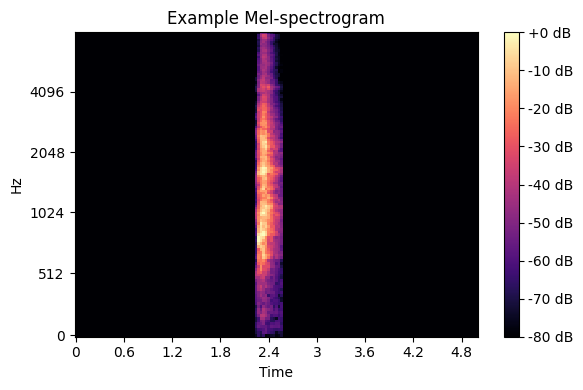

In [21]:
plt.figure(figsize=(6, 4))
librosa.display.specshow(melspec, sr=TARGET_SR,
                         x_axis='time', y_axis='mel')
plt.colorbar(format="%+2.0f dB")
plt.title("Example Mel-spectrogram")
plt.tight_layout()
plt.show()


In [22]:
# ============================================
# 6. TRAIN / VAL / TEST SPLITS WITH FOLDS
# ============================================

from sklearn.preprocessing import LabelEncoder
from collections import Counter
import numpy as np

# ------------------------------
# 1) Encode class labels
# ------------------------------
# meta['category'] is the string label (e.g. "dog")
label_encoder = LabelEncoder()
meta['label'] = label_encoder.fit_transform(meta['category'])

n_classes = len(label_encoder.classes_)
print("Number of classes:", n_classes)
print("Classes:", list(label_encoder.classes_))

# Quick check: distribution of labels
print("\nLabel distribution (all folds):")
print(Counter(meta['label']))

# ------------------------------
# 2) Define which folds go where
# ------------------------------
# ESC-50 has folds 1..5. We choose:
TRAIN_FOLDS = [1, 2, 3]
VAL_FOLDS   = [4]
TEST_FOLDS  = [5]

print("\nUsing folds")
print("Train folds:", TRAIN_FOLDS)
print("Val folds:  ", VAL_FOLDS)
print("Test folds: ", TEST_FOLDS)

# ------------------------------
# 3) Generic feature builder
# ------------------------------
def build_feature_set(meta_df, folds, feature_type="mfcc_mean"):
    """
    Build X, y for the given folds and feature type.

    feature_type:
        - "mfcc_mean" : time-averaged MFCCs (for MLP baseline)
        - "mfcc_seq"  : full MFCC sequences (for LSTM/GRU)
        - "melspec"   : log-Mel spectrograms (for CNN)
    """
    subset = meta_df[meta_df['fold'].isin(folds)]

    X = []
    y = []

    for _, row in subset.iterrows():
        filename = row['filename']
        label = row['label']

        # 1) Load waveform (resampled, mono, fixed length)
        signal = load_waveform(filename)

        # 2) Extract the right type of feature
        if feature_type == "mfcc_mean":
            mfcc_seq = extract_mfcc_sequence(signal)
            feat = mfcc_mean_from_sequence(mfcc_seq)          # shape (n_mfcc,)

        elif feature_type == "mfcc_seq":
            feat = extract_mfcc_sequence(signal)              # shape (T, n_mfcc)

        elif feature_type == "melspec":
            feat = extract_melspectrogram(signal)             # shape (n_mels, T)

        else:
            raise ValueError(f"Unknown feature_type: {feature_type}")

        X.append(feat)
        y.append(label)

    return X, np.array(y, dtype=np.int64)

# ------------------------------
# 4) Build MFCC-mean features (for MLP baseline)
# ------------------------------
X_train_mfcc_mean, y_train = build_feature_set(
    meta, TRAIN_FOLDS, feature_type="mfcc_mean"
)
X_val_mfcc_mean,   y_val   = build_feature_set(
    meta, VAL_FOLDS, feature_type="mfcc_mean"
)
X_test_mfcc_mean,  y_test  = build_feature_set(
    meta, TEST_FOLDS, feature_type="mfcc_mean"
)

# Convert lists -> numpy arrays
X_train_mfcc_mean = np.stack(X_train_mfcc_mean).astype("float32")
X_val_mfcc_mean   = np.stack(X_val_mfcc_mean).astype("float32")
X_test_mfcc_mean  = np.stack(X_test_mfcc_mean).astype("float32")

print("\nMFCC-mean features (for MLP):")
print("Train:", X_train_mfcc_mean.shape, y_train.shape)
print("Val:  ", X_val_mfcc_mean.shape,   y_val.shape)
print("Test: ", X_test_mfcc_mean.shape,  y_test.shape)

# ------------------------------
# 5) (Optional) Build MFCC sequences (for LSTM later)
# ------------------------------
X_train_mfcc_seq, y_train_seq = build_feature_set(
    meta, TRAIN_FOLDS, feature_type="mfcc_seq"
)
X_val_mfcc_seq,   y_val_seq   = build_feature_set(
    meta, VAL_FOLDS, feature_type="mfcc_seq"
)
X_test_mfcc_seq,  y_test_seq  = build_feature_set(
    meta, TEST_FOLDS, feature_type="mfcc_seq"
)

print("\nNumber of MFCC sequences (train/val/test):",
      len(X_train_mfcc_seq), len(X_val_mfcc_seq), len(X_test_mfcc_seq))
print("Example MFCC sequence shape:", X_train_mfcc_seq[0].shape)
# (Later we will pad these sequences to a fixed length for batching.)

# ------------------------------
# 6) (Optional) Build Mel-spectrograms (for CNN later)
# ------------------------------
X_train_melspec, y_train_cnn = build_feature_set(
    meta, TRAIN_FOLDS, feature_type="melspec"
)
X_val_melspec,   y_val_cnn   = build_feature_set(
    meta, VAL_FOLDS, feature_type="melspec"
)
X_test_melspec,  y_test_cnn  = build_feature_set(
    meta, TEST_FOLDS, feature_type="melspec"
)

print("\nNumber of Mel-spectrograms (train/val/test):",
      len(X_train_melspec), len(X_val_melspec), len(X_test_melspec))
print("Example Mel-spectrogram shape:", X_train_melspec[0].shape)
# Later we'll pad/crop and reshape them to (H, W, 1) for the CNN.


Number of classes: 50
Classes: ['airplane', 'breathing', 'brushing_teeth', 'can_opening', 'car_horn', 'cat', 'chainsaw', 'chirping_birds', 'church_bells', 'clapping', 'clock_alarm', 'clock_tick', 'coughing', 'cow', 'crackling_fire', 'crickets', 'crow', 'crying_baby', 'dog', 'door_wood_creaks', 'door_wood_knock', 'drinking_sipping', 'engine', 'fireworks', 'footsteps', 'frog', 'glass_breaking', 'hand_saw', 'helicopter', 'hen', 'insects', 'keyboard_typing', 'laughing', 'mouse_click', 'pig', 'pouring_water', 'rain', 'rooster', 'sea_waves', 'sheep', 'siren', 'sneezing', 'snoring', 'thunderstorm', 'toilet_flush', 'train', 'vacuum_cleaner', 'washing_machine', 'water_drops', 'wind']

Label distribution (all folds):
Counter({18: 40, 7: 40, 46: 40, 43: 40, 20: 40, 3: 40, 16: 40, 9: 40, 23: 40, 6: 40, 0: 40, 33: 40, 35: 40, 45: 40, 39: 40, 48: 40, 8: 40, 10: 40, 31: 40, 49: 40, 24: 40, 25: 40, 13: 40, 2: 40, 4: 40, 14: 40, 28: 40, 21: 40, 36: 40, 30: 40, 32: 40, 29: 40, 22: 40, 1: 40, 17: 40, 27:

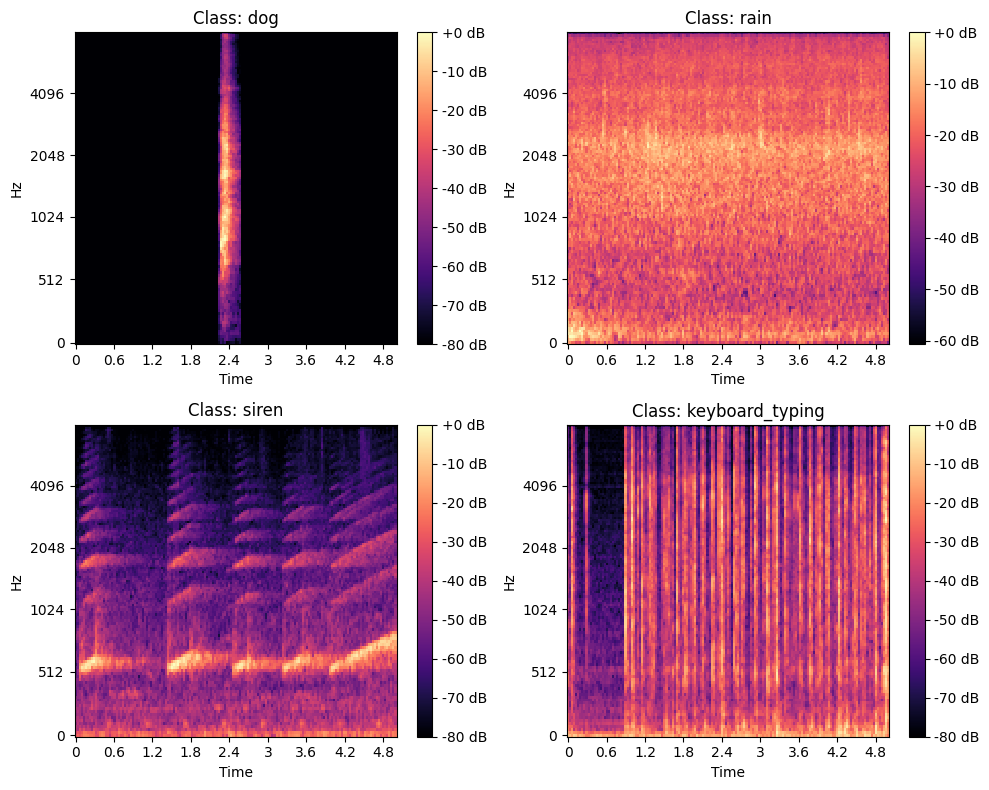

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import librosa.display  # if not already imported

example_classes = ["dog", "rain", "siren", "keyboard_typing"]  # you can change these
rows = []

for cls in example_classes:
    row_cls = meta[meta["category"] == cls].iloc[0]
    rows.append(row_cls)

plt.figure(figsize=(10, 8))

for i, row in enumerate(rows):
    filename = row["filename"]
    label = row["category"]

    y_std = load_waveform(filename)
    melspec = extract_melspectrogram(y_std)      # shape (128, T)

    plt.subplot(2, 2, i + 1)
    librosa.display.specshow(
        melspec,
        sr=TARGET_SR,
        x_axis="time",
        y_axis="mel"
    )
    plt.title(f"Class: {label}")
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout()

plt.savefig("eda_melspectrograms_4classes.png", dpi=300)
plt.show()


Baseline Model (MLP)

Train: (1200, 40) (1200,)
Val:   (400, 40) (400,)
Test:  (400, 40) (400,)
Input dim: 40
Number of classes: 50


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         3,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,754 (65.45 KB)

 Trainable params: 16,754 (65.45 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0258 - loss: 4.0134 - val_accuracy: 0.0350 - val_loss: 3.8928
Epoch 2/80
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0433 - loss: 3.8564 - val_accuracy: 0.0575 - val_loss: 3.8287
Epoch 3/80
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0483 - loss: 3.7738 - val_accuracy: 0.0875 - val_loss: 3.7676
Epoch 4/80
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0792 - loss: 3.6713 - val_accuracy: 0.0925 - val_loss: 3.6912
Epoch 5/80
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0883 - loss: 3.5897 - val_accuracy: 0.1025 - val_loss: 3.6083
Epoch 6/80
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1167 - loss: 3.4947 - val_accuracy: 0.1200 - val_loss: 3.5133
Epoch 7/80
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1625 - loss: 3.3588 - val_accuracy: 0.1475 - val_loss: 3.4076
Epoch 8/80
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1433 - loss: 3.2918 - val_accuracy: 0.1725 - val_loss

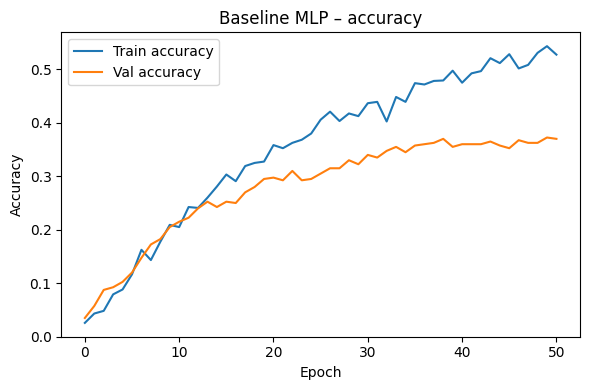

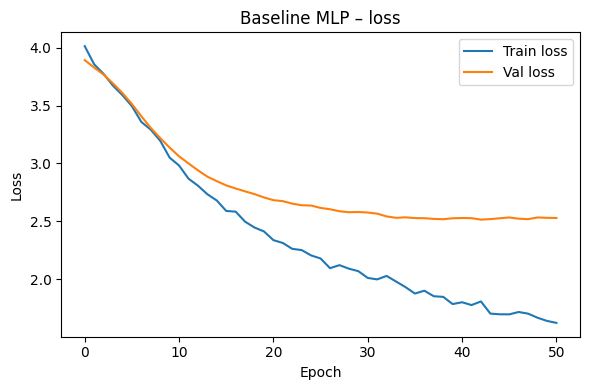

=== Final evaluation ===
Train accuracy: 0.718
Val accuracy:   0.360
Test accuracy:  0.290
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Confusion matrix (test):
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 1 0 0]
 [0 0 4 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 2]]

Classification report (test):
              precision    recall  f1-score   support

           0      0.143     0.125     0.133         8
           1      0.250     0.125     0.167         8
           2      0.667     0.500     0.571         8
           3      0.154     0.250     0.190         8
           4      0.333     0.250     0.286         8
           5      0.000     0.000     0.000         8
           6      0.308     0.500     0.381         8
           7      0.000     0.000     0.000         8
           8      0.333     0.250     0.286         8
           9      0.300     0.375     0.333         8
          10      0.700     0.875     0.778         8
          11      0.143     0.125     0.133 

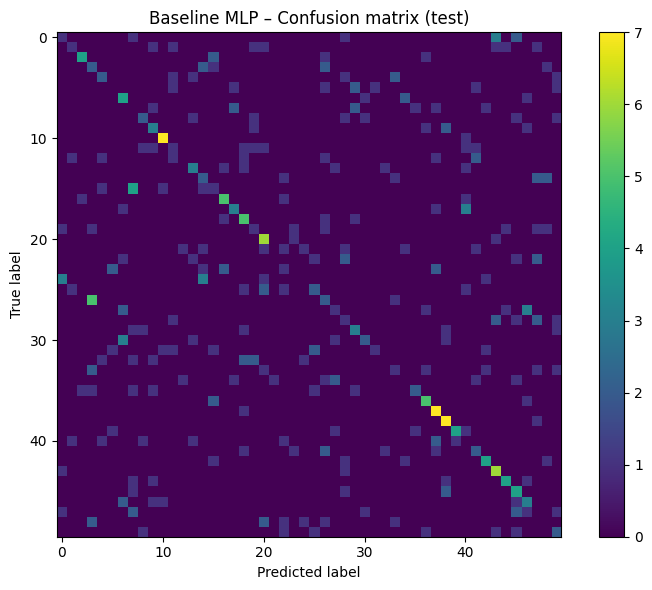

In [24]:
# ==============================
# 1. Imports
# ==============================
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Just to be sure: check shapes
print("Train:", X_train_mfcc_mean.shape, y_train.shape)
print("Val:  ", X_val_mfcc_mean.shape,   y_val.shape)
print("Test: ", X_test_mfcc_mean.shape,  y_test.shape)

# ==============================
# 2. Basic normalisation (optional but recommended)
# ==============================
# Standardise features using training statistics
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_mfcc_mean)
X_val   = scaler.transform(X_val_mfcc_mean)
X_test  = scaler.transform(X_test_mfcc_mean)

input_dim = X_train.shape[1]
print("Input dim:", input_dim)
print("Number of classes:", n_classes)

# ==============================
# 3. Build the MLP model
# ==============================
tf.random.set_seed(42)

model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# ==============================
# 4. Training with early stopping
# ==============================
early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=8,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# ==============================
# 5. Plot training / validation curves
# ==============================
# Accuracy
plt.figure(figsize=(6,4))
plt.plot(history.history["accuracy"], label="Train accuracy")
plt.plot(history.history["val_accuracy"], label="Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Baseline MLP – accuracy")
plt.legend()
plt.tight_layout()
plt.savefig("mlp_baseline_accuracy.png", dpi=300)
plt.show()

# Loss
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Baseline MLP – loss")
plt.legend()
plt.tight_layout()
plt.savefig("mlp_baseline_loss.png", dpi=300)
plt.show()

# ==============================
# 6. Evaluation on train/val/test
# ==============================
print("=== Final evaluation ===")
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
val_loss,   val_acc   = model.evaluate(X_val,   y_val,   verbose=0)
test_loss,  test_acc  = model.evaluate(X_test,  y_test,  verbose=0)

print(f"Train accuracy: {train_acc:.3f}")
print(f"Val accuracy:   {val_acc:.3f}")
print(f"Test accuracy:  {test_acc:.3f}")

# ==============================
# 7. Confusion matrix and report on test set
# ==============================
y_test_pred_proba = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

cm = confusion_matrix(y_test, y_test_pred)
print("Confusion matrix (test):")
print(cm)

print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred, digits=3))

# Optional: plot confusion matrix as image
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation="nearest")
plt.title("Baseline MLP – Confusion matrix (test)")
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.savefig("mlp_baseline_confusion_matrix.png", dpi=300)
plt.show()


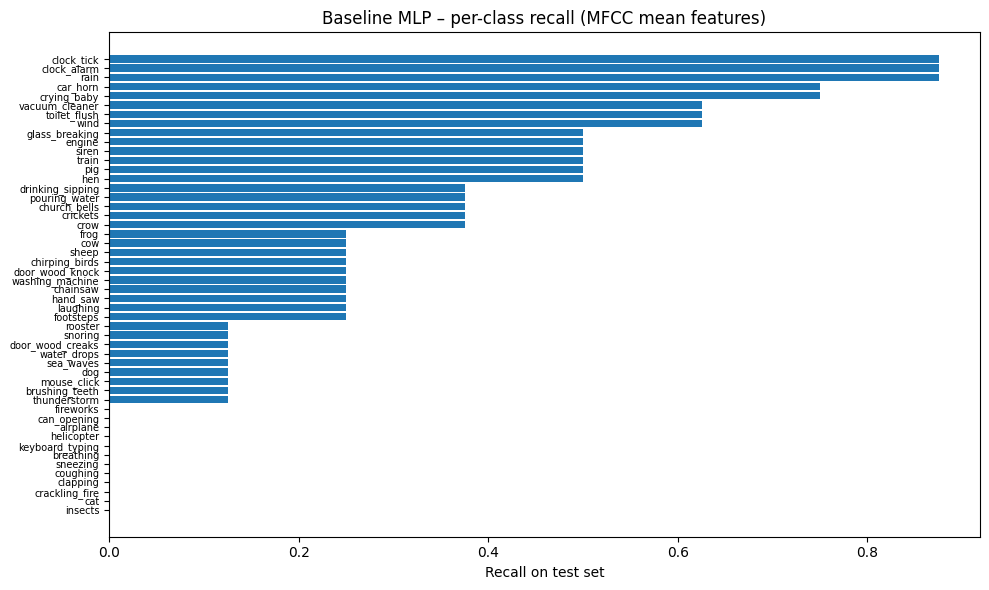

In [26]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
id_to_name = {row['target']: row['category'] for _, row in meta.iterrows()}

# classification report as dict (no noisy warnings)
report = classification_report(
    y_test, y_test_pred,
    digits=3,
    output_dict=True,
    zero_division=0
)

# assuming you have a mapping from id -> class name
# for example:
# id_to_name = {row['target']: row['category'] for _, row in meta.iterrows()}
# build ordered lists
class_ids = sorted([int(k) for k in report.keys() if k.isdigit()])
class_names = [id_to_name[i] for i in class_ids]
recalls = [report[str(i)]['recall'] for i in class_ids]

# sort by recall (worst to best) so it's clearer
order = np.argsort(recalls)
recalls_sorted = [recalls[i] for i in order]
names_sorted = [class_names[i] for i in order]

plt.figure(figsize=(10, 6))
plt.barh(range(len(names_sorted)), recalls_sorted)
plt.yticks(range(len(names_sorted)), names_sorted, fontsize=7)
plt.xlabel("Recall on test set")
plt.title("Baseline MLP – per-class recall (MFCC mean features)")
plt.tight_layout()
plt.savefig("mlp_baseline_per_class_recall.png", dpi=300)
plt.show()


In [27]:
# build a small summary table in Python
worst_idx = order[:3]
best_idx = order[-3:]

print("Worst classes:")
for i in worst_idx:
    print(class_ids[i], class_names[i], "recall =", recalls[i])

print("\nBest classes:")
for i in best_idx:
    print(class_ids[i], class_names[i], "recall =", recalls[i])


Worst classes:
7 insects recall = 0.0
5 cat recall = 0.0
12 crackling_fire recall = 0.0

Best classes:
10 rain recall = 0.875
37 clock_alarm recall = 0.875
38 clock_tick recall = 0.875
